# Analyze the masks and contours

This notebook allows you to analyze the masks and their respective contours on which ICP will be applied to.

This requires an import of the masks, which you can save as `.pkl`, and load it here in the notebook under `directory`.

You can see that the first time IoU is applied, the match is not perfect (Cell 8), but by reinitializing the IoU four times at different rotation angles of the object in the video, we obtain a near perfect match (Cell 13).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import re
from typing import Literal

In [2]:
# Get pre-computed masks from disk
masks = {}

masks['ref'] = {}
directory = 'temp_results/masks/ref' # Directory containing reference masks
pattern = re.compile(r'mask_(\d+)\.pkl')
for filename in os.listdir(directory):
    match = pattern.match(filename)
    if match:
        mask_number = int(match.group(1))  # extract the frame number
        filepath = os.path.join(directory, filename)
        with open(filepath, 'rb') as f:
            mask = pickle.load(f)
        masks['ref'][mask_number] = mask

# Masks of video frames 
masks['video'] = {}
directory = 'temp_masks/12/run2' # Directory containing video masks

pattern = re.compile(r'frame_(\d+)\.pkl')
for filename in os.listdir(directory):
    match = pattern.match(filename)
    if match:
        frame_number = int(match.group(1))  # extract the frame number
        filepath = os.path.join(directory, filename)
        with open(filepath, 'rb') as f:
            mask = pickle.load(f)
        masks['video'][frame_number] = mask

In [14]:
def display_mask(nbr: int, domain = Literal["ref", "video"],masks = masks):
    """Displays boolean mask, white == True, black == False."""
    mask = masks[domain][nbr]
    plt.imshow(mask, cmap='gray')  # 'gray' makes True=white, False=black
    plt.title(f"Boolean Mask\n{"Reference" if domain == "ref" else "Frame"} {nbr}")
    plt.axis('off')  # Hide axes for cleaner display
    plt.show()

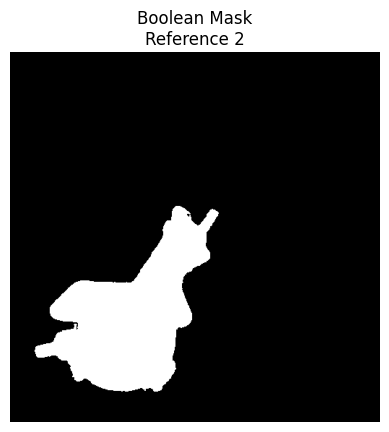

In [15]:
display_mask(2, "ref", masks=masks)

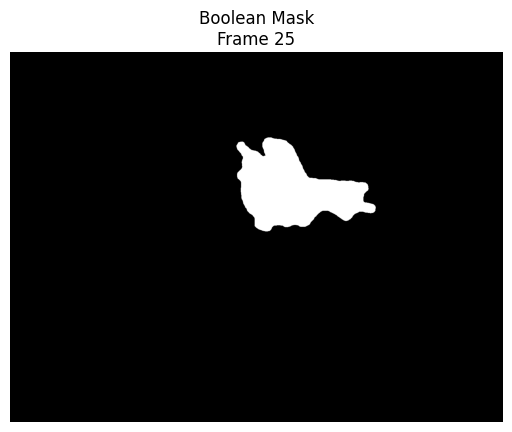

In [16]:
display_mask(25, "video", masks=masks)

In [23]:
def crop_mask(mask: np.ndarray) -> np.ndarray:
    if not np.any(mask):
        return np.zeros((0, 0), dtype=bool)  # or return the original mask if preferred

    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)

    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return mask[rmin:rmax+1, cmin:cmax+1]

In [24]:
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.draw import polygon
from sklearn.neighbors import NearestNeighbors

# -------------------------
# ICP UTILITIES (your code)
# -------------------------

def euclidean_distance(point1, point2):
    a = np.array(point1)
    b = np.array(point2)
    return np.linalg.norm(a - b, ord=2)

def point_based_matching(point_pairs):
    x_mean = y_mean = xp_mean = yp_mean = 0
    n = len(point_pairs)

    if n == 0:
        return None, None, None, None

    for (x, y), (xp, yp) in point_pairs:
        x_mean += x
        y_mean += y
        xp_mean += xp
        yp_mean += yp

    x_mean /= n
    y_mean /= n
    xp_mean /= n
    yp_mean /= n

    s_x_xp = s_y_yp = s_x_yp = s_y_xp = 0
    sigma_xx = sigma_yy = 0
    for (x, y), (xp, yp) in point_pairs:
        dx = x - x_mean
        dy = y - y_mean
        dxp = xp - xp_mean
        dyp = yp - yp_mean

        s_x_xp += dx * dxp
        s_y_yp += dy * dyp
        s_x_yp += dx * dyp
        s_y_xp += dy * dxp

        sigma_xx += dx * dx
        sigma_yy += dy * dy

    rot_angle = math.atan2(s_x_yp - s_y_xp, s_x_xp + s_y_yp)
    c, s = math.cos(rot_angle), math.sin(rot_angle)

    numerator = s_x_xp + s_y_yp
    denominator = sigma_xx + sigma_yy
    scale = numerator / denominator if denominator != 0 else 1.0

    tx = xp_mean - scale * (x_mean * c - y_mean * s)
    ty = yp_mean - scale * (x_mean * s + y_mean * c)

    return rot_angle, tx, ty, scale

def icp(reference_points, points, max_iterations=200, distance_threshold=20.0,
        convergence_translation_threshold=1e-3, convergence_rotation_threshold=1e-4,
        convergence_scale_threshold=1e-4, point_pairs_threshold=5, verbose=False):
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='kd_tree').fit(reference_points)
    src = points.copy()

    # Cumulative transformation: initialize
    total_rotation = 0.0
    total_scale = 1.0
    total_translation = np.zeros(2)

    for iter_num in range(max_iterations):
        if verbose:
            print(f'--- ICP Iteration {iter_num} ---')

        closest_point_pairs = []

        distances, indices = nbrs.kneighbors(src)
        for i in range(len(distances)):
            if distances[i][0] < distance_threshold:
                closest_point_pairs.append((src[i], reference_points[indices[i][0]]))

        if verbose:
            print(f'Point pairs found: {len(closest_point_pairs)}')
        if len(closest_point_pairs) < point_pairs_threshold:
            if verbose:
                print("Too few point pairs — stopping.")
            break

        angle, tx, ty, scale = point_based_matching(closest_point_pairs)
        if angle is None:
            break

        # Compose this iteration's transform
        c, s = math.cos(angle), math.sin(angle)
        R = np.array([[c, -s], [s, c]])
        src = scale * (src @ R.T)
        src[:, 0] += tx
        src[:, 1] += ty

        # Update cumulative transform
        total_rotation += angle
        total_scale *= scale
        total_translation = scale * (total_translation @ R.T) + [tx, ty]

        if abs(angle) < convergence_rotation_threshold and \
            abs(tx) < convergence_translation_threshold and \
            abs(ty) < convergence_translation_threshold and \
            abs(scale-1) < convergence_scale_threshold:
            if verbose:
                print(f"Converged after {iter_num+1} iterations.")
            break

    # Return final aligned points and full transformation
    transform = {
        "rotation": total_rotation,                 # angle in radians
        "scale": total_scale,                       # scalar
        "translation": total_translation.tolist(),  # [tx, ty]
    }

    return transform, src

# -------------------------
# IOU + ALIGNMENT
# -------------------------

def get_largest_contour(mask):
    mask_u8 = (mask.astype(np.uint8)) * 255
    contours, _ = cv2.findContours(mask_u8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return None
    return max(contours, key=cv2.contourArea)[:, 0, :].astype(np.float32)

def contour_to_mask(shape, contour):
    rr, cc = polygon(contour[:, 1], contour[:, 0], shape)
    mask = np.zeros(shape, dtype=bool)
    mask[rr, cc] = True
    return mask

def get_aligned_iou(mask, mask_ref, max_points=200):
    """
    mask: mask of the current object to be matched to the mask of reference object (mask_ref)
    """
    mask1 = crop_mask(mask_ref)
    mask2 = crop_mask(mask)

    contour1 = get_largest_contour(mask1)
    contour2 = get_largest_contour(mask2)
    if contour1 is None or contour2 is None:
        return 0.0

    N = min(len(contour1), len(contour2), max_points)
    idx1 = np.linspace(0, len(contour1) - 1, N).astype(int)
    idx2 = np.linspace(0, len(contour2) - 1, N).astype(int)
    points1 = contour1[idx1]
    points2 = contour2[idx2]

    trans, aligned_points2 = icp(
		reference_points=points1,
		points=points2,
		max_iterations=200,
        point_pairs_threshold=N//10,
		distance_threshold=300,
		convergence_translation_threshold=1e-3,
		convergence_rotation_threshold=1e-4,
		convergence_scale_threshold=1e-3,
		verbose=False
    )

    aligned_mask = contour_to_mask(mask1.shape, aligned_points2)

    intersection = np.logical_and(mask1, aligned_mask).sum()
    union = np.logical_or(mask1, aligned_mask).sum()
    iou = intersection / union if union > 0 else 0.0
    return iou, trans

# -------------------------
# OPTIONAL: Visualization
# -------------------------

def plot_contours(*contours, colors=None, labels=None, figsize=(6, 6), title="Contours"):
    plt.figure(figsize=figsize)
    for i, contour in enumerate(contours):
        # Default color cycle
        color = colors[i] if colors and i < len(colors) else None
        label = labels[i] if labels and i < len(labels) else f"Mask {i+1}"
        plt.plot(contour[:, 0], contour[:, 1], label=label, color=color)

    plt.gca().invert_yaxis()  # image coordinates: origin at top-left
    plt.gca().set_aspect('equal')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


In [25]:
mask1 = crop_mask(masks["ref"][2])
mask2 = crop_mask(masks["video"][25])

contour1 = get_largest_contour(mask1)
contour2 = get_largest_contour(mask2)

N = min(len(contour1), len(contour2), 200)
idx1 = np.linspace(0, len(contour1) - 1, N).astype(int)
idx2 = np.linspace(0, len(contour2) - 1, N).astype(int)
points1 = contour1[idx1]
points2 = contour2[idx2]

tran, aligned_points2 = icp(
    reference_points=points1,
    points=points2,
    max_iterations=200,
    point_pairs_threshold=N//10,
    distance_threshold=150,
    convergence_translation_threshold=1e-3,
    convergence_rotation_threshold=1e-4,
    convergence_scale_threshold=1e-3,
    verbose=True
)

aligned_mask2 = contour_to_mask(mask1.shape, aligned_points2)

intersection = np.logical_and(mask1, aligned_mask2).sum()
union = np.logical_or(mask1, aligned_mask2).sum()
res = intersection / union if union > 0 else 0.0

print(f"\nIoU: {res}")

print(f"\nTransformations:\n{tran}")

--- ICP Iteration 0 ---
Point pairs found: 159
--- ICP Iteration 1 ---
Point pairs found: 200
--- ICP Iteration 2 ---
Point pairs found: 200
--- ICP Iteration 3 ---
Point pairs found: 200
--- ICP Iteration 4 ---
Point pairs found: 200
--- ICP Iteration 5 ---
Point pairs found: 200
--- ICP Iteration 6 ---
Point pairs found: 200
--- ICP Iteration 7 ---
Point pairs found: 200
--- ICP Iteration 8 ---
Point pairs found: 200
--- ICP Iteration 9 ---
Point pairs found: 200
--- ICP Iteration 10 ---
Point pairs found: 200
--- ICP Iteration 11 ---
Point pairs found: 200
--- ICP Iteration 12 ---
Point pairs found: 200
--- ICP Iteration 13 ---
Point pairs found: 200
--- ICP Iteration 14 ---
Point pairs found: 200
--- ICP Iteration 15 ---
Point pairs found: 200
--- ICP Iteration 16 ---
Point pairs found: 200
--- ICP Iteration 17 ---
Point pairs found: 200
--- ICP Iteration 18 ---
Point pairs found: 200
--- ICP Iteration 19 ---
Point pairs found: 200
--- ICP Iteration 20 ---
Point pairs found: 200
--

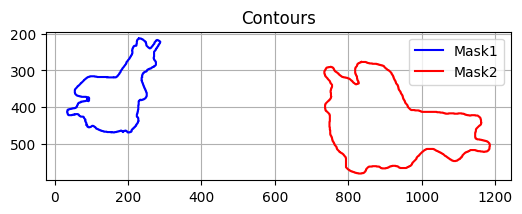

In [26]:
# Plot contours
mask1 = masks["ref"][2]
mask2 = masks["video"][25]

plot_contours(
    get_largest_contour(mask1),
    get_largest_contour(mask2),
    colors=["blue", "red"],
    labels=["Mask1", "Mask2"]
)


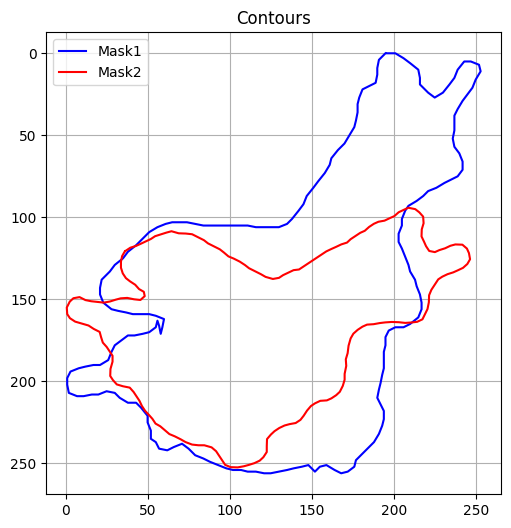

In [27]:
from skimage.draw import disk

# Plot contours
plot_contours(
    points1,
    aligned_points2,
    colors=["blue", "red"],
    labels=["Mask1", "Mask2"]
)


In [28]:
def rotate_contour(contour, angle):
    """Rotate contour by a given angle (in radians) around its centroid."""
    angle = np.radians(angle)
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    contour = contour @ rotation_matrix.T

    # Translate the contour so that the top-left corner of its bounding box is at (0, 0)
    min_x, min_y = np.min(contour, axis=0)
    contour -= [min_x, min_y]

    return contour

In [29]:
def get_best_iou(mask_ref, mask2):
    """
    mask2: mask of the current object to be matched to the mask of reference object (mask_ref)
    rotate mask1 to find the best iou with mask2 (ref_mask)
    """
    mask1 = crop_mask(mask_ref)
    mask2 = crop_mask(mask2)

    contour1 = get_largest_contour(mask1)
    contour2 = get_largest_contour(mask2)
    if contour1 is None or contour2 is None:
        return 0.0

    iou = []
    trans = []
    for angle in range(0,360,90):
        rot_contour = rotate_contour(contour2, angle)
        N = min(len(contour1), len(rot_contour), 200)
        idx1 = np.linspace(0, len(contour1) - 1, N).astype(int)
        idx2 = np.linspace(0, len(rot_contour) - 1, N).astype(int)
        points1 = contour1[idx1]
        points2 = rot_contour[idx2]

        tran, aligned_points2 = icp(
            reference_points=points1,
            points=points2,
            max_iterations=200,
            point_pairs_threshold=N//10,
            distance_threshold=150,
            convergence_translation_threshold=1e-3,
            convergence_rotation_threshold=1e-4,
            convergence_scale_threshold=1e-3,
            verbose=False
        )

        aligned_mask2 = contour_to_mask(mask1.shape, aligned_points2)

        intersection = np.logical_and(mask1, aligned_mask2).sum()
        union = np.logical_or(mask1, aligned_mask2).sum()
        res = intersection / union if union > 0 else 0.0
        iou.append(res)
        trans.append(tran)
    #return the highest iou
    return max(iou), trans[iou.index(max(iou))]

In [30]:
mask1 = crop_mask(masks["ref"][2])
mask2 = crop_mask(masks["video"][25])

contour1 = get_largest_contour(mask1)
contour2 = get_largest_contour(mask2)

iou = []
trans = []
for angle in range(0,360,90):
    rot_contour = rotate_contour(contour2, angle)
    N = min(len(contour1), len(rot_contour), 200)
    idx1 = np.linspace(0, len(contour1) - 1, N).astype(int)
    idx2 = np.linspace(0, len(rot_contour) - 1, N).astype(int)
    points1 = contour1[idx1]
    points2 = rot_contour[idx2]

    tran, aligned_points2 = icp(
        reference_points=points1,
        points=points2,
        max_iterations=200,
        point_pairs_threshold=N//10,
        distance_threshold=150,
        convergence_translation_threshold=1e-3,
        convergence_rotation_threshold=1e-4,
        convergence_scale_threshold=1e-3,
        verbose=False
    )

    aligned_mask2 = contour_to_mask(mask1.shape, aligned_points2)

    intersection = np.logical_and(mask1, aligned_mask2).sum()
    union = np.logical_or(mask1, aligned_mask2).sum()
    res = intersection / union if union > 0 else 0.0
    iou.append(res)
    trans.append(tran)
#return the highest iou
best_iou = max(iou)
tran = trans[iou.index(max(iou))]

In [31]:
print(best_iou)
print(tran)

0.9028738281850315
{'rotation': 0.4650601167876323, 'scale': np.float64(0.6410705394185741), 'translation': [117.52587216913756, -55.787416662170116]}


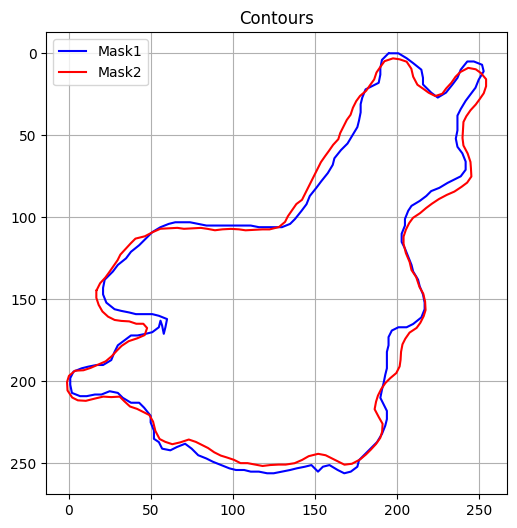

In [ ]:
# Plot contours
plot_contours(
    points1,
    aligned_points2,
    colors=["blue", "red"],
    labels=["Mask1", "Mask2"]
)


## Analysis of an occluded object

We can see that our ICP algorithm now blows up the contour to match the reference object. However, the IoU is still poor (0.49).

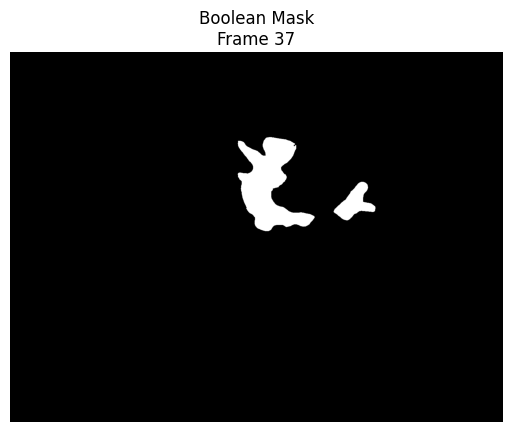

In [22]:
display_mask(37, "video")

0.497367527173913
{'rotation': -0.18964904003542543, 'scale': np.float64(0.7728838802887606), 'translation': [-7.4667325164541065, 67.69090429462433]}


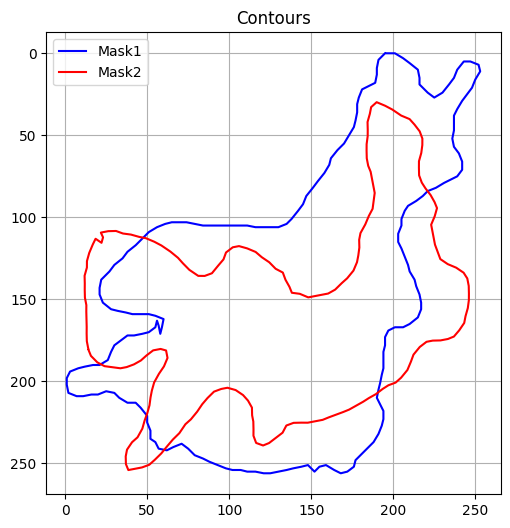

In [32]:
mask1 = crop_mask(masks["ref"][2])
mask2 = crop_mask(masks["video"][37])

contour1 = get_largest_contour(mask1)
contour2 = get_largest_contour(mask2)

iou = []
trans = []
for angle in range(0,360,90):
    rot_contour = rotate_contour(contour2, angle)
    N = min(len(contour1), len(rot_contour), 200)
    idx1 = np.linspace(0, len(contour1) - 1, N).astype(int)
    idx2 = np.linspace(0, len(rot_contour) - 1, N).astype(int)
    points1 = contour1[idx1]
    points2 = rot_contour[idx2]

    tran, aligned_points2 = icp(
        reference_points=points1,
        points=points2,
        max_iterations=200,
        point_pairs_threshold=N//10,
        distance_threshold=150,
        convergence_translation_threshold=1e-3,
        convergence_rotation_threshold=1e-4,
        convergence_scale_threshold=1e-3,
        verbose=False
    )

    aligned_mask2 = contour_to_mask(mask1.shape, aligned_points2)

    intersection = np.logical_and(mask1, aligned_mask2).sum()
    union = np.logical_or(mask1, aligned_mask2).sum()
    res = intersection / union if union > 0 else 0.0
    iou.append(res)
    trans.append(tran)
#return the highest iou
best_iou = max(iou)
tran = trans[iou.index(max(iou))]

print(best_iou)
print(tran)


# Plot contours
plot_contours(
    points1,
    aligned_points2,
    colors=["blue", "red"],
    labels=["Mask1", "Mask2"]
)
